In [1]:
# =============================================================================
# ### 1. Impor Pustaka 📚
# =============================================================================
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler # <-- Tambahkan MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
print("✅ Pustaka berhasil diimpor.")

✅ Pustaka berhasil diimpor.


In [2]:
# =============================================================================
# ### 2. Memuat Data Log Normal 📂
# =============================================================================
file_path = 'data/syslog.txt'
raw_logs = []
try:
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        raw_logs = f.readlines()
    print(f"✅ Berhasil memuat {len(raw_logs)} baris log.")
except FileNotFoundError:
    print(f"❌ Error: File tidak ditemukan di {file_path}")
print("\n📋 Pratinjau Data Log Mentah (5 baris pertama):")
for log in raw_logs[:5]: print(log.strip())

✅ Berhasil memuat 2667 baris log.

📋 Pratinjau Data Log Mentah (5 baris pertama):
"date=2024-12-18 time=00:04:12 devname=scientia_potentia_est devid=FGT80C3913601127 logid=""0001000014"" type=""traffic"" subtype=""local"" level=""notice"" vd=""root"" srcip=3.101.239.87 srcport=51000 srcintf=""wan2"" dstip=103.118.101.210 dstport=10000 dstintf=""root"" sessionid=5585128 proto=6 action=""deny"" policyid=0 policytype=""local-in-policy"" dstcountry=""Indonesia"" srccountry=""United States"" trandisp=""noop"" service=""tcp/10000"" app=""tcp/10000"" duration=0 sentbyte=0 rcvdbyte=0 sentpkt=0 appcat=""unscanned"" crscore=30 craction=131072 crlevel=""high"""
"devname: scientia_potentia_est"
"date=2024-12-18 time=00:04:11 devname=scientia_potentia_est devid=FGT80C3913601127 logid=""0001000014"" type=""traffic"" subtype=""local"" level=""notice"" vd=""root"" srcip=3.101.239.87 srcport=19277 srcintf=""wan2"" dstip=103.118.101.210 dstport=15 dstintf=""root"" sessionid=5585116 proto=6 action=""deny

In [3]:
# =============================================================================
# ### 3. Pembersihan dan Parsing Data Log 🧹
# =============================================================================
def parse_log_line(line):
    log_dict = {}
    pattern = re.compile(r'(\w+)=(?:"([^"]*)"|(\S+))')
    matches = pattern.findall(line)
    for key, val_quoted, val_unquoted in matches:
        log_dict[key] = val_quoted if val_quoted else val_unquoted
    return log_dict
parsed_logs = [parse_log_line(line) for line in raw_logs if line.strip()]
print(f"\n✅ Berhasil mem-parsing {len(parsed_logs)} baris log.")
print("\n📋 Pratinjau Data Log yang Sudah Diparsing (3 baris pertama):")
for log in parsed_logs[:3]: print(log)


✅ Berhasil mem-parsing 2667 baris log.

📋 Pratinjau Data Log yang Sudah Diparsing (3 baris pertama):
{'date': '2024-12-18', 'time': '00:04:12', 'devname': 'scientia_potentia_est', 'devid': 'FGT80C3913601127', 'logid': '', 'type': '', 'subtype': '', 'level': '', 'vd': '', 'srcip': '3.101.239.87', 'srcport': '51000', 'srcintf': '', 'dstip': '103.118.101.210', 'dstport': '10000', 'dstintf': '', 'sessionid': '5585128', 'proto': '6', 'action': '', 'policyid': '0', 'policytype': '', 'dstcountry': '', 'srccountry': '', 'trandisp': '', 'service': '', 'app': '', 'duration': '0', 'sentbyte': '0', 'rcvdbyte': '0', 'sentpkt': '0', 'appcat': '', 'crscore': '30', 'craction': '131072', 'crlevel': ''}
{}
{'date': '2024-12-18', 'time': '00:04:11', 'devname': 'scientia_potentia_est', 'devid': 'FGT80C3913601127', 'logid': '', 'type': '', 'subtype': '', 'level': '', 'vd': '', 'srcip': '3.101.239.87', 'srcport': '19277', 'srcintf': '', 'dstip': '103.118.101.210', 'dstport': '15', 'dstintf': '', 'sessionid

In [4]:
# =============================================================================
# ### 4. Transformasi ke Bentuk Tabular (DataFrame) 📊
# =============================================================================
df_logs = pd.DataFrame(parsed_logs)
print("\n✅ Berhasil membuat DataFrame.")
# Kolom yang mungkin tampak numerik tapi kita perlakukan sebagai string/object
categorical_like_numeric = ['srcport', 'dstport', 'crscore', 'proto', 'policyid']
for col in categorical_like_numeric:
    if col in df_logs.columns:
        df_logs[col] = df_logs[col].astype(str).fillna('Unknown')
    else:
        df_logs[col] = 'Unknown'
# Kolom numerik murni (tidak akan kita gunakan sekarang, tapi biarkan untuk kelengkapan)
numerical_cols_true = ['sessionid', 'sentbyte', 'rcvdbyte', 'sentpkt', 'duration']
for col in numerical_cols_true:
    if col in df_logs.columns:
        df_logs[col] = pd.to_numeric(df_logs[col], errors='coerce').fillna(0)
print("\n📋 Pratinjau DataFrame (5 baris pertama):")
print(df_logs.head())
print("\nℹ️ Informasi DataFrame:")
df_logs.info()


✅ Berhasil membuat DataFrame.

📋 Pratinjau DataFrame (5 baris pertama):
         date      time                devname             devid logid type  \
0  2024-12-18  00:04:12  scientia_potentia_est  FGT80C3913601127              
1         NaN       NaN                    NaN               NaN   NaN  NaN   
2  2024-12-18  00:04:11  scientia_potentia_est  FGT80C3913601127              
3  2024-12-18  00:04:11  scientia_potentia_est  FGT80C3913601127              
4  2024-12-18  00:04:10  scientia_potentia_est  FGT80C3913601127              

  subtype level   vd         srcip  ... sentbyte rcvdbyte sentpkt appcat  \
0                     3.101.239.87  ...      0.0      0.0     0.0          
1     NaN   NaN  NaN           NaN  ...      0.0      0.0     0.0    NaN   
2                     3.101.239.87  ...      0.0      0.0     0.0          
3                     3.101.239.87  ...      0.0      0.0     0.0          
4                     3.101.239.87  ...      0.0      0.0     0.0       

In [5]:
# =============================================================================
# ### 5. Pra-pemrosesan Data (Feature Engineering & Scaling) ⚙️ - Revisi Fitur
# =============================================================================
# --- PERUBAHAN: Gunakan fitur yang lebih sedikit ---
features_to_use = [
    'srcip', 'srccountry', 'dstport', 'action', 'proto', 'service'
]
available_features = [f for f in features_to_use if f in df_logs.columns]
print(f"\nFitur yang akan digunakan: {available_features}")
df_processed = df_logs[available_features].copy()

# Pastikan semua fitur diperlakukan sebagai string & tangani NaN
for col in df_processed.columns:
    df_processed[col] = df_processed[col].astype(str).fillna('Unknown')

# --- SEMUA FITUR ADALAH KATEGORIKAL SEKARANG ---
categorical_cols = df_processed.columns
numerical_cols = pd.Index([]) # <-- Tidak ada kolom numerik

print(f"\nFitur Kategorikal: {list(categorical_cols)}")
print(f"Fitur Numerik: {list(numerical_cols)}")

# Terapkan Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
print("\n✅ Fitur kategorikal telah dikodekan.")

# --- PERUBAHAN BARU: Terapkan MinMaxScaler ---
print("\nMenerapkan MinMaxScaler untuk menormalkan data ke rentang [0, 1]...")
scaler = MinMaxScaler() # <-- Gunakan MinMaxScaler
df_processed = pd.DataFrame(scaler.fit_transform(df_processed), columns=df_processed.columns)
print("✅ Semua fitur telah diskalakan ke [0, 1].")
# --- PERUBAHAN SELESAI ---

print("\n✅ Pra-pemrosesan data selesai.")
print("\n📋 Pratinjau DataFrame Siap Latih (5 baris pertama):")
print(df_processed.head())
print("\nℹ️ Informasi DataFrame Setelah Pra-pemrosesan:")
df_processed.info()


Fitur yang akan digunakan: ['srcip', 'srccountry', 'dstport', 'action', 'proto', 'service']

Fitur Kategorikal: ['srcip', 'srccountry', 'dstport', 'action', 'proto', 'service']
Fitur Numerik: []

✅ Fitur kategorikal telah dikodekan.

Menerapkan MinMaxScaler untuk menormalkan data ke rentang [0, 1]...
✅ Semua fitur telah diskalakan ke [0, 1].

✅ Pra-pemrosesan data selesai.

📋 Pratinjau DataFrame Siap Latih (5 baris pertama):
      srcip  srccountry   dstport  action     proto  service
0  0.944444         0.0  0.000000     0.0  0.666667      0.0
1  1.000000         1.0  1.000000     1.0  1.000000      1.0
2  0.944444         0.0  0.208333     0.0  0.666667      0.0
3  0.944444         0.0  0.750000     0.0  0.666667      0.0
4  0.944444         0.0  0.500000     0.0  0.666667      0.0

ℹ️ Informasi DataFrame Setelah Pra-pemrosesan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ----


🧠 Model Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)


⏳ Memulai pelatihan Autoencoder...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1502 - val_loss: 0.1513
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1309 - val_loss: 0.1367
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1089 - val_loss: 0.1214
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900 - val_loss: 0.1074
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0771 - val_loss: 0.0943
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0636 - val_loss: 0.0820
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 - val_loss: 0.0751
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - val_loss: 0.0690
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - val_loss: 0.0634
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336 - val_loss: 0.0560
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - val_loss: 0.0528
Epoch 12/100
36/36 ━━━━━━━━

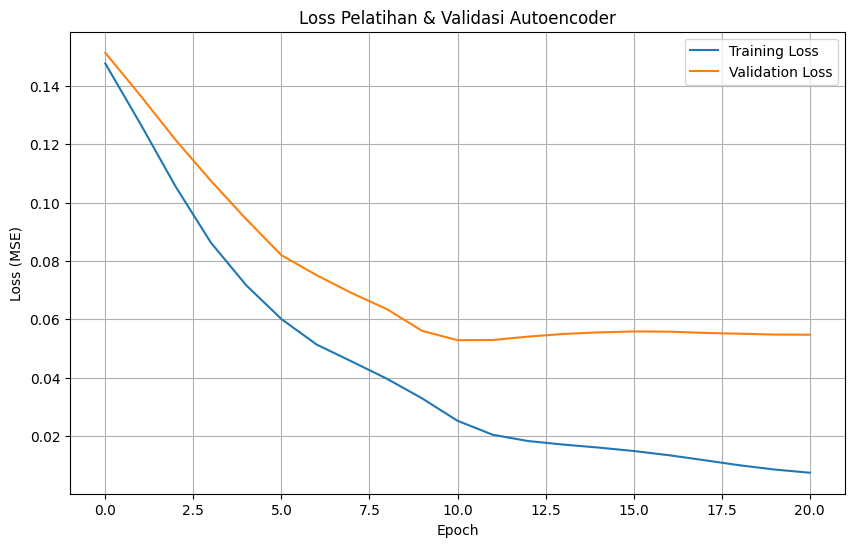

💾 Model Autoencoder disimpan ke: trained_models\autoencoder_model.keras


In [6]:
# =============================================================================
# ### 6. Melatih Model Autoencoder 🤖
# =============================================================================
input_dim = df_processed.shape[1]
encoding_dim = max(8, int(input_dim / 2))
hidden_dim = max(4, int(encoding_dim / 2))
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print("\n🧠 Model Autoencoder:")
autoencoder.summary()
print("\n⏳ Memulai pelatihan Autoencoder...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(df_processed, df_processed, epochs=100, batch_size=64, shuffle=True, validation_split=0.15, callbacks=[early_stopping], verbose=1)
print("\n✅ Pelatihan Autoencoder Selesai.")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Pelatihan & Validasi Autoencoder'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True); plt.show()
output_dir = 'trained_models'; os.makedirs(output_dir, exist_ok=True)
autoencoder_save_path = os.path.join(output_dir, 'autoencoder_model.keras')
autoencoder.save(autoencoder_save_path)
print(f"💾 Model Autoencoder disimpan ke: {autoencoder_save_path}")


--- Visualisasi Reconstruction Error Autoencoder ---
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


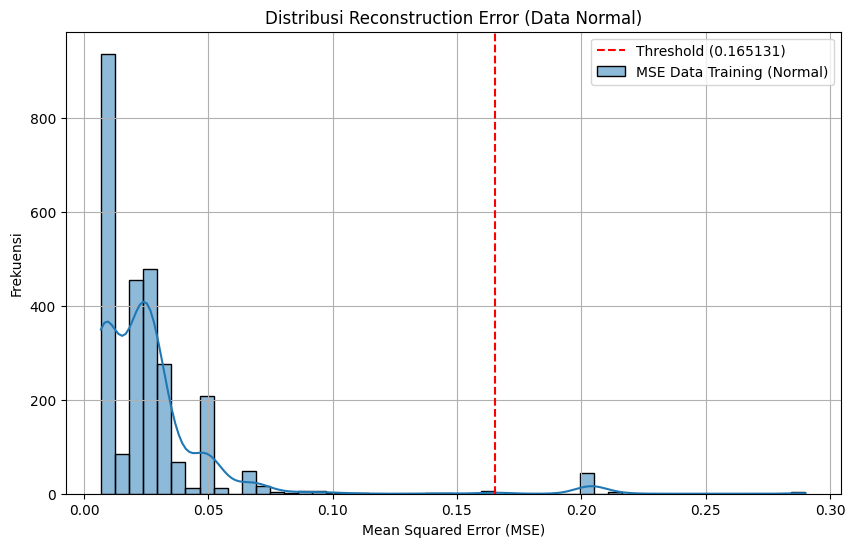


--- Penjelasan Grafik Reconstruction Error ---
Grafik ini menunjukkan distribusi Mean Squared Error (MSE) antara data log normal asli dan hasil rekonstruksinya oleh Autoencoder.
MSE mengukur seberapa baik model dapat 'membangun kembali' data input setelah melalui proses kompresi (encoding) dan dekompresi (decoding).

Interpretasi:
- Sebagian besar data normal memiliki MSE yang rendah (terkonsentrasi di sisi kiri grafik), karena model dilatih untuk mengenali pola-pola ini.
- Garis merah putus-putus menunjukkan 'threshold' (nilai ambang batas) yang ditetapkan pada persentil ke-98, yaitu 0.165131.
- Ini berarti 98% data training normal memiliki MSE *di bawah* threshold ini.
- Dalam praktiknya, jika ada data log baru yang memiliki MSE *di atas* threshold ini, kita akan menganggapnya sebagai **anomali**, karena model kesulitan merekonstruksinya, menandakan bahwa data tersebut berbeda signifikan dari pola normal yang telah dipelajari.


In [7]:
# =============================================================================
# ### 6.1. Visualisasi & Penjelasan Reconstruction Error (Autoencoder) 📈
# =============================================================================
print("\n--- Visualisasi Reconstruction Error Autoencoder ---")
reconstructions = autoencoder.predict(df_processed)
mse = np.mean(np.power(df_processed - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 98)

plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=50, kde=True, label='MSE Data Training (Normal)')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6f})')
plt.title('Distribusi Reconstruction Error (Data Normal)')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frekuensi')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Penjelasan Grafik Reconstruction Error ---")
print("Grafik ini menunjukkan distribusi Mean Squared Error (MSE) antara data log normal asli dan hasil rekonstruksinya oleh Autoencoder.")
print("MSE mengukur seberapa baik model dapat 'membangun kembali' data input setelah melalui proses kompresi (encoding) dan dekompresi (decoding).")
print("\nInterpretasi:")
print(f"- Sebagian besar data normal memiliki MSE yang rendah (terkonsentrasi di sisi kiri grafik), karena model dilatih untuk mengenali pola-pola ini.")
print(f"- Garis merah putus-putus menunjukkan 'threshold' (nilai ambang batas) yang ditetapkan pada persentil ke-98, yaitu {threshold:.6f}.")
print(f"- Ini berarti 98% data training normal memiliki MSE *di bawah* threshold ini.")
print(f"- Dalam praktiknya, jika ada data log baru yang memiliki MSE *di atas* threshold ini, kita akan menganggapnya sebagai **anomali**, karena model kesulitan merekonstruksinya, menandakan bahwa data tersebut berbeda signifikan dari pola normal yang telah dipelajari.")


In [8]:
# =============================================================================
# ### 7. Melatih Model One-Class SVM (OCSVM) 🛡️
# =============================================================================
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
print("\n⏳ Memulai pelatihan One-Class SVM...")
ocsvm.fit(df_processed)
print("✅ Pelatihan One-Class SVM Selesai.")
ocsvm_save_path = os.path.join(output_dir, 'ocsvm_model.pkl')
joblib.dump(ocsvm, ocsvm_save_path)
print(f"💾 Model OCSVM disimpan ke: {ocsvm_save_path}")


⏳ Memulai pelatihan One-Class SVM...
✅ Pelatihan One-Class SVM Selesai.
💾 Model OCSVM disimpan ke: trained_models\ocsvm_model.pkl



--- Visualisasi Batas Keputusan OCSVM (Aproksimasi 2D) ---
⚠️ Catatan: Ini adalah aproksimasi 2D menggunakan PCA untuk tujuan ilustrasi.


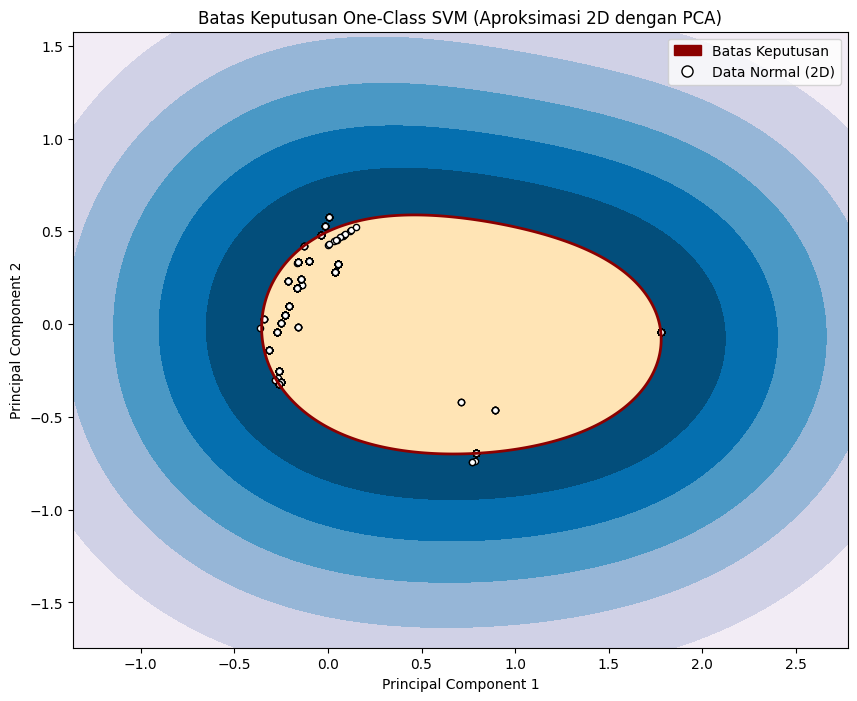


--- Penjelasan Grafik Batas Keputusan OCSVM ---
Grafik ini mencoba memvisualisasikan bagaimana One-Class SVM 'menggambar batas' di sekitar data normal, meskipun dalam versi 2D yang disederhanakan menggunakan PCA.

Interpretasi:
- Titik-titik putih (dengan tepi hitam) merepresentasikan data log normal kita setelah direduksi menjadi 2 dimensi.
- Garis merah tebal adalah 'batas keputusan' yang dipelajari oleh OCSVM. Ini adalah garis yang mencoba 'membungkus' sebagian besar data normal.
- Area berwarna kuning muda (moccasin) di dalam garis batas adalah wilayah yang dianggap **normal** oleh model.
- Area berwarna biru (PuBu) di luar garis batas adalah wilayah yang akan dianggap **anomali** oleh model.
- Tujuan OCSVM adalah membuat batas ini seketat mungkin di sekitar data normal, sambil memperhitungkan parameter 'nu' (perkiraan persentase data yang mungkin dianggap 'salah' atau outlier). Jika data baru jatuh di area biru, ia akan ditandai sebagai anomali.


In [9]:
# =============================================================================
# ### 7.1. Visualisasi & Penjelasan Batas Keputusan OCSVM (Aproksimasi 2D) 🗺️
# =============================================================================
print("\n--- Visualisasi Batas Keputusan OCSVM (Aproksimasi 2D) ---")
print("⚠️ Catatan: Ini adalah aproksimasi 2D menggunakan PCA untuk tujuan ilustrasi.")

pca = PCA(n_components=2)
data_2d = pca.fit_transform(df_processed)
ocsvm_2d = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm_2d.fit(data_2d)

x_min, x_max = data_2d[:, 0].min() - 1, data_2d[:, 0].max() + 1
y_min, y_max = data_2d[:, 1].min() - 1, data_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = ocsvm_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.title("Batas Keputusan One-Class SVM (Aproksimasi 2D dengan PCA)")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu) # Area anomali (biru tua)
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='moccasin') # Area normal (kuning muda)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
s = plt.scatter(data_2d[:, 0], data_2d[:, 1], c='white', s=20, edgecolors='k')

red_patch = mpatches.Patch(color='darkred', label='Batas Keputusan')
white_dot = plt.Line2D([0], [0], marker='o', color='w', label='Data Normal (2D)',
                          markerfacecolor='white', markeredgecolor='k', markersize=8, linestyle='None')
plt.legend(handles=[red_patch, white_dot], loc="upper right")
plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2'); plt.axis('tight'); plt.show()

print("\n--- Penjelasan Grafik Batas Keputusan OCSVM ---")
print("Grafik ini mencoba memvisualisasikan bagaimana One-Class SVM 'menggambar batas' di sekitar data normal, meskipun dalam versi 2D yang disederhanakan menggunakan PCA.")
print("\nInterpretasi:")
print(f"- Titik-titik putih (dengan tepi hitam) merepresentasikan data log normal kita setelah direduksi menjadi 2 dimensi.")
print(f"- Garis merah tebal adalah 'batas keputusan' yang dipelajari oleh OCSVM. Ini adalah garis yang mencoba 'membungkus' sebagian besar data normal.")
print(f"- Area berwarna kuning muda (moccasin) di dalam garis batas adalah wilayah yang dianggap **normal** oleh model.")
print(f"- Area berwarna biru (PuBu) di luar garis batas adalah wilayah yang akan dianggap **anomali** oleh model.")
print(f"- Tujuan OCSVM adalah membuat batas ini seketat mungkin di sekitar data normal, sambil memperhitungkan parameter 'nu' (perkiraan persentase data yang mungkin dianggap 'salah' atau outlier). Jika data baru jatuh di area biru, ia akan ditandai sebagai anomali.")

In [10]:
# =============================================================================
# ### 8. Menyimpan Artefak Pra-pemrosesan 📦
# =============================================================================
print(f"\n📁 Menyimpan artefak ke direktori: {output_dir}")
le_path = os.path.join(output_dir, 'label_encoders.pkl')
joblib.dump(label_encoders, le_path)
print(f"💾 Label Encoders disimpan ke: {le_path}")
if scaler:
    sc_path = os.path.join(output_dir, 'scaler.pkl')
    joblib.dump(scaler, sc_path)
    print(f"💾 Scaler disimpan ke: {sc_path}")
else:
    print("ℹ️ Tidak ada Scaler untuk disimpan.")
cols_path = os.path.join(output_dir, 'model_columns.pkl')
joblib.dump(df_processed.columns.tolist(), cols_path)
print(f"💾 Daftar kolom model disimpan ke: {cols_path}")
print("\n✨ Semua model dan artefak telah disimpan di direktori 'trained_models'.")

# =============================================================================
# ### 9. Selesai! 🎉
# =============================================================================
print("\nProses pelatihan dan penyimpanan model (dengan visualisasi) selesai.")
print("Model dan artefak siap digunakan oleh 'streamlit_app.py' dan 'models.py'.")


📁 Menyimpan artefak ke direktori: trained_models
💾 Label Encoders disimpan ke: trained_models\label_encoders.pkl
💾 Scaler disimpan ke: trained_models\scaler.pkl
💾 Daftar kolom model disimpan ke: trained_models\model_columns.pkl

✨ Semua model dan artefak telah disimpan di direktori 'trained_models'.

Proses pelatihan dan penyimpanan model (dengan visualisasi) selesai.
Model dan artefak siap digunakan oleh 'streamlit_app.py' dan 'models.py'.
